# Clustering RNA sequences to identify cancer types

Use clustering algorithms on RNA sequence data to identify cancer types. 
The data contains 5 labels; BRCA, KIRC, COAD, LUAD and PRAD of different cancer types
- BRCA - Breast invasive carcinoma
- KIRC - Kidney renal clear cell carcinoma
- COAD - Colon adenocarcinoma
- LUAD - Lung adenocarcinoma
- PRAD - Prostate adenocarcinoma

This dataset is hosted at UC Irvine Machine Learning Repository

https://archive.ics.uci.edu/

https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq

The original data set (large) is maintained by the cancer genome atlas pan-cancer analysis project.

hosted at https://www.synapse.org/#!Synapse:syn4301332

Good Referecnce: 

https://pmc.ncbi.nlm.nih.gov/articles/PMC3919969/

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Import and Inspect Data

In [2]:
data = pd.read_csv('data/PanCanData.csv')
labels = pd.read_csv('data/PanCanLabels.csv')
data = data.drop('Unnamed: 0', axis=1)
labels = labels.drop('Unnamed: 0', axis=1)

In [3]:
print('\n------------------------------- Top of Data -----------------------------------------')
print(data.head())
print('\n------------------------------- Top of Labels ---------------------------------------')
print(labels.head())
print('\n------------------------------ Data Information -------------------------------------')
print(data.info())
print('\n--------------------------- Descriptive Statistics ----------------------------------')
print(data.describe())



------------------------------- Top of Data -----------------------------------------
   gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0     0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1     0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2     0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3     0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4     0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   

     gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
0  0.591871     0.0     0.0  ...    4.926711    8.210257    9.723516   
1  0.000000     0.0     0.0  ...    4.593372    7.323865    9.740931   
2  0.452595     0.0     0.0  ...    5.125213    8.127123   10.908640   
3  0.434882     0.0     0.0  ...    6.076566    8.792959   10.141520   
4  0.360982     0.0     0.0  ...    5.996032    8.891425   10.373790   

   gene_20524  gene_20525  gene_20526  gene_205

In [ ]:
print(data.isna().sum())

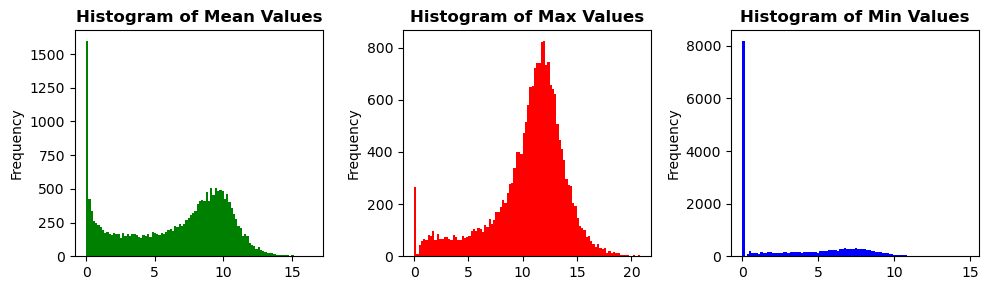

In [4]:
mean_values = data.mean()
max_values = data.max()
min_values = data.min()

fig, ax = plt.subplots(1, 3, figsize = (10, 3))
plt.subplots_adjust(hspace=1)

# Mean Histogram
ax[0].hist(mean_values, bins=100, color='green')
ax[0].set_title('Histogram of Mean Values', fontweight='bold')
ax[0].set_xlabel('')
ax[0].set_ylabel('Frequency')

# Max Histogram
ax[1].hist(max_values, bins=100, color='red')
ax[1].set_title('Histogram of Max Values', fontweight='bold')
ax[1].set_xlabel('')
ax[1].set_ylabel('Frequency')

# Min Histogram
ax[2].hist(min_values, bins=100, color='blue')
ax[2].set_title('Histogram of Min Values', fontweight='bold')
ax[2].set_xlabel('')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
# save fig optional          
#plt.savefig('results/gene_max_min_ave_distributions.jpg') 

plt.show()

In [ ]:
zeros = (mean_values == 0).sum()
non_zeros = (mean_values != 0).sum()
print(zeros)
print(non_zeros)

**The data appears to already be noramlized in some way**

log plus one transformations
- RNA-seq data can be very skewed with a long right tail (genes that are highly expressed)
    - compress highly expressed genes
    - spread out low expression 
    - allow distributions to be compared


- The x-axis represents the normalized expression of a gene.
- The y-axis shows how many genes fall into each bin of the histogram.

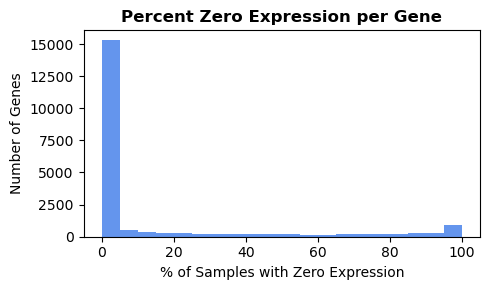

In [7]:

percent_zeros = (data == 0).sum(axis=0) / data.shape[0] * 100 # sum samples with 0 expression for a certain gene/ total # samples

plt.figure(figsize=(5,3))
plt.hist(percent_zeros, bins=20, color='cornflowerblue')
plt.title("Percent Zero Expression per Gene", fontweight='bold')
plt.xlabel("% of Samples with Zero Expression")
plt.ylabel("Number of Genes")

plt.tight_layout()
# save fig optional
#plt.savefig('results/percent_zero_expression.jpg') 
plt.show()

- Large spike at 0% zeros indicates groups of genes are expressed in every sample or nearly every sample.
- Drop in the middle of the distribution means there aren’t many genes that are expressed only in some samples.
- Increase at ~100% zeros indicates genes that are never or rarely detected. 

## Models

### Agglomerative Clustering
- Does not assume spherical clusters
- Works well with hierarchical data

In [8]:
# AgglomerativeClustering model with # clusters = 5 (5 cancer types), ward linkage, and euclidean distance
agg_model = AgglomerativeClustering(n_clusters=5, linkage='ward', metric='euclidean')
# fit the model
agg_predictions = agg_model.fit_predict(data)
# print out results
print("Cluster Labels:")
print(agg_predictions)

Cluster Labels:
[2 3 2 2 0 2 1 2 0 2 0 1 2 0 0 0 3 1 1 2 0 1 3 0 1 3 4 0 0 0 0 0 1 0 2 0 1
 3 0 0 1 2 2 1 1 0 2 4 0 3 0 3 0 2 4 0 0 4 1 0 3 1 0 3 2 4 0 2 1 0 1 0 0 3
 0 3 0 1 2 4 0 2 0 0 2 2 0 0 1 0 2 2 0 0 0 2 4 0 2 0 0 1 0 1 3 1 3 4 3 3 2
 0 3 2 0 1 1 1 0 0 3 1 3 0 2 2 2 0 1 0 4 0 4 0 0 1 3 0 1 4 0 2 0 1 3 4 2 0
 3 3 3 3 0 0 3 0 0 2 2 3 2 3 1 0 2 3 4 1 3 0 1 3 0 3 0 0 0 2 0 1 4 1 0 2 2
 2 3 3 0 3 3 1 3 2 3 0 0 0 3 3 0 1 1 1 1 2 0 2 0 3 3 0 2 0 2 0 0 0 3 0 1 3
 1 1 3 0 1 2 0 3 3 2 4 0 1 2 1 4 0 1 1 3 2 2 3 3 1 0 0 4 0 2 4 0 2 1 2 2 2
 0 4 4 3 4 4 2 3 0 0 1 1 0 4 2 1 2 0 0 1 0 0 0 0 3 3 0 0 0 1 1 1 1 0 0 0 1
 0 0 3 2 0 0 4 3 2 0 0 0 4 0 2 0 4 3 3 2 1 0 1 1 3 4 1 0 0 0 0 1 0 0 2 0 1
 0 3 2 1 0 2 4 0 0 0 3 3 3 0 0 2 3 0 1 0 4 4 3 0 1 0 0 0 4 3 4 1 2 1 0 0 1
 0 4 2 3 2 0 1 2 0 4 1 1 4 4 2 0 0 4 1 3 2 0 0 0 3 3 1 3 0 1 4 2 0 3 2 0 0
 0 3 0 0 2 0 2 4 0 3 0 0 3 0 0 0 1 3 2 0 2 1 0 1 4 0 2 3 1 0 0 1 0 3 0 0 2
 4 0 1 3 2 0 2 0 0 0 0 1 3 0 1 0 0 3 3 1 4 2 4 0 1 1 0 2 1 4 3 3 0 2 2 0 2
 3 1 2 0 

### KMeans Clustering with PCA Reduced Data

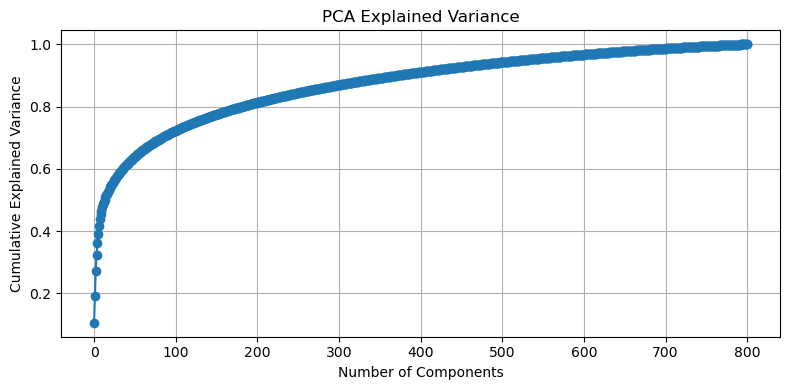

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

pca = PCA().fit(X_scaled)
explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(explained, marker = 'o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()
# save fig optional
#plt.savefig('results/pca_explained_variance.jpg')
plt.show()


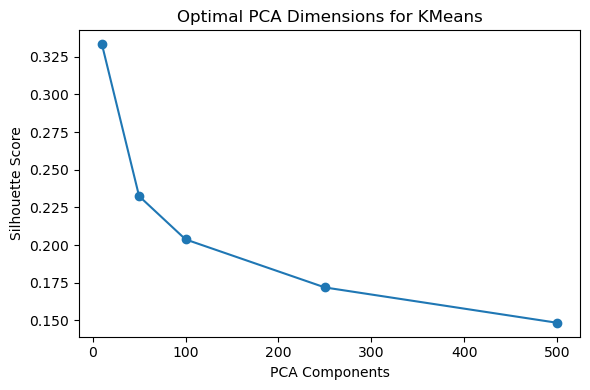

In [11]:
candidate_dims = [10, 50, 100, 250, 500]
scores = []

for k in candidate_dims:
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)
    
    model = KMeans(n_clusters=5, random_state=42)
    preds = model.fit_predict(X_pca)
    
    score = silhouette_score(X_pca, preds)
    scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(candidate_dims, scores, marker='o')
plt.xlabel("PCA Components")
plt.ylabel("Silhouette Score")
plt.title("Optimal PCA Dimensions for KMeans")
plt.tight_layout()
# save fig optional
#plt.savefig('results/optimal_pca_dims_kmeans.jpg') 
plt.show()


In [12]:
# K-Means model with # clusters = 5 (5 cancer types), PCA Reduced Data with 100 components
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)
km_model = KMeans(n_clusters=5, random_state=42)
# fit the model
km_predictions = km_model.fit_predict(X_pca)
# print out results
print("Cluster Labels:")
print(km_predictions)

Cluster Labels:
[1 0 1 1 4 1 2 1 4 1 4 2 1 0 4 4 0 2 2 1 4 2 0 4 2 0 3 4 0 4 4 4 2 0 1 4 2
 0 4 0 2 1 1 2 2 4 1 3 4 0 4 0 4 1 3 0 4 3 2 4 0 0 4 0 1 3 4 1 2 0 2 4 0 0
 4 0 4 0 1 3 4 1 4 4 1 1 4 4 2 0 1 1 4 0 4 1 3 4 1 4 4 2 4 2 0 2 0 3 0 0 1
 4 0 1 4 2 2 2 4 4 0 2 0 4 1 1 1 4 2 4 3 0 3 4 4 2 0 4 2 3 4 1 4 2 0 3 1 4
 0 0 0 0 4 4 0 4 4 1 1 0 1 0 2 4 1 0 3 2 0 4 2 0 4 0 4 0 4 1 4 2 3 2 4 1 1
 1 0 0 4 0 0 2 0 1 0 4 0 4 0 0 4 2 2 2 2 1 0 1 0 0 0 4 1 4 1 4 4 4 0 4 2 0
 2 2 0 4 2 1 4 0 0 1 3 0 2 1 2 3 0 2 2 0 1 0 0 0 2 4 0 3 4 1 0 4 1 2 1 1 1
 4 3 3 0 3 3 1 0 4 4 2 2 4 3 1 2 1 4 4 2 4 4 4 0 0 0 4 4 4 2 2 2 2 0 4 4 2
 4 4 0 1 4 4 3 0 1 4 4 4 3 4 1 4 3 0 0 1 2 4 2 2 4 3 2 4 4 4 4 2 4 4 1 0 2
 4 0 1 2 4 1 3 0 4 4 0 0 0 4 4 1 0 4 2 4 3 3 0 4 2 4 4 0 3 0 3 2 1 2 0 4 2
 4 3 1 0 1 0 2 1 4 3 2 2 3 3 1 4 0 3 2 0 1 0 4 4 0 0 2 0 0 2 3 1 4 0 1 4 0
 4 0 4 0 1 4 1 3 4 0 4 4 0 4 4 4 2 0 1 4 1 2 0 2 3 4 1 0 2 4 4 2 4 0 0 4 1
 3 4 2 0 1 4 1 4 4 4 4 2 0 0 2 4 4 0 0 2 3 1 3 4 2 2 4 1 2 3 0 0 4 1 1 0 1
 0 2 1 4 

In [13]:
import itertools

def attach_labels(labels,ypred,n=5):
    """
    Function to attach labels to clusters based on best accuracy
    
    labels: labels dataframe object
    ypred: clustering model predictions
    
    Returns permuted label order and accuracy. 
    """
    # actual labels and predicted labels
    actual_labels = labels['Class'].values  
    label_options = ['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD']

    # initialize variables to store results
    acc = 0.0
    best_label_order = None

    # all possible label orderings
    label_permutations = itertools.permutations(label_options)

    for label_order in label_permutations:
        # mapping from numeric cluster labels to the current label permutation
        label_mapping = {i: label_order[i] for i in range(n)}

        # map the cluster labels to actual labels using the current mapping
        mapped_labels = np.array([label_mapping[label] for label in ypred])

        # accuracy of the current label permutation
        accuracy = accuracy_score(actual_labels, mapped_labels)

        # determine best accuracy and label order
        if accuracy > acc:
            acc = accuracy
            best_label_order = label_order
            
    # mapping from numeric labels to best permuted labels
    best_label_mapping = {i: best_label_order[i] for i in range(n)}
    # get the best label assignments
    best_labels_with_assignment = [best_label_mapping[label] for label in ypred]

    return best_label_mapping, acc
    

In [14]:
agg_labelorder, agg_acc = attach_labels(labels, agg_model.labels_)
print(agg_labelorder, agg_acc)


{0: 'BRCA', 1: 'KIRC', 2: 'PRAD', 3: 'LUAD', 4: 'COAD'} 0.9950062421972534


<Figure size 400x400 with 0 Axes>

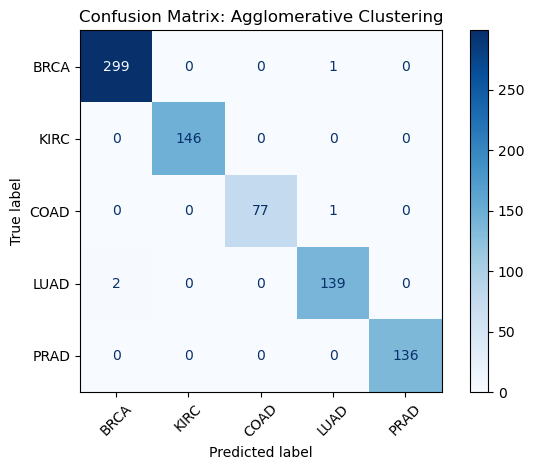

In [16]:
# Mapped predictions
mapped_predictions = [agg_labelorder[label] for label in agg_model.labels_]
# Create confusion matrix
y_true = labels['Class'].values
y_pred = mapped_predictions

cm = confusion_matrix(y_true, y_pred, labels=['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD'])

# Display confusion matrix
plt.figure(figsize=(4,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Agglomerative Clustering")
plt.tight_layout()
# save matrix, optional
#plt.savefig('results/confusion_matrix_agg_clustering.jpg')
plt.show()

In [17]:
km_labelorder, km_acc = attach_labels(labels, km_model.labels_)
print(km_labelorder, km_acc)

{0: 'LUAD', 1: 'PRAD', 2: 'KIRC', 3: 'COAD', 4: 'BRCA'} 0.9213483146067416


<Figure size 400x400 with 0 Axes>

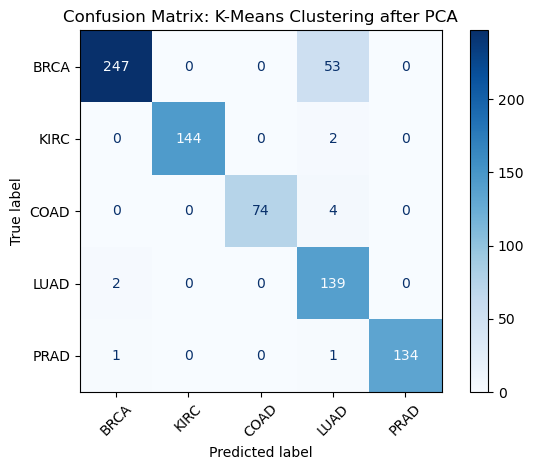

In [18]:
# Mapped predictions
mapped_predictions = [km_labelorder[label] for label in km_model.labels_]
# Create confusion matrix
y_true = labels['Class'].values
y_pred = mapped_predictions

cm = confusion_matrix(y_true, y_pred, labels=['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD'])

# Display confusion matrix
plt.figure(figsize=(4,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: K-Means Clustering after PCA")
plt.tight_layout()
# save matrix, optional
#plt.savefig('results/confusion_matrix_pca_kmeans_clustering.jpg')
plt.show()